First we load the data, the models, and their return predictions.

We add a day to the df index because:
1. when we stored the test_predictions, we used the last N days of available data.
2. this means that we predict the last N-1 days and the day after.

In [24]:
tickers = ["BTCUSDT", "DOGEUSDT", "ETHUSDT", "SOLUSDT", "XRPUSDT"]

import pandas as pd
import joblib
%store -r test_predictions
pred_close = pd.DataFrame(test_predictions)
pred_close.index = pred_close.index + pd.Timedelta(days=1)

for ticker in tickers:
    scaler = joblib.load(f"scalers/{ticker}_scaler.pkl")
    seventeen_columns = pd.concat([pred_close[ticker]] * 17, axis=1)

    pred_close[ticker] = scaler.inverse_transform(seventeen_columns)[:, 0]


In [25]:
pred_close

,SOLUSDT,BTCUSDT,ETHUSDT,DOGEUSDT,XRPUSDT
Open time,,,,,
2023-08-15,24.214575,29023.707031,1898.484863,0.075153,0.611887
2023-08-16,25.371572,29111.404297,1877.519531,0.074107,0.619048
2023-08-17,25.181650,28824.435547,1857.801392,0.071008,0.612686
2023-08-18,23.714766,28445.283203,1841.678955,0.068384,0.600292
2023-08-19,23.495745,27580.748047,1827.796875,0.064237,0.573166
...,...,...,...,...,...
2023-12-28,99.620476,41528.375000,2237.231201,0.088778,0.630629
2023-12-29,99.846687,41984.835938,2303.459961,0.089474,0.636581
2023-12-30,98.331749,41617.531250,2312.554932,0.088417,0.641065


In [26]:
import data
import pandas as pd, numpy as np

if "USDT" in tickers: tickers.remove("USDT")
dfs = [data.load_asset(ticker, sampling="1d") for ticker in tickers]
dfs = [data.subset(df, start=pd.Timestamp('2021-01-01'), end=pd.Timestamp('2024-01-03')) for df in dfs]
dfs = [data.add_returns(df) for df in dfs]
dfs = [df.dropna() for df in dfs]

opens = pd.concat([df["Open"] for df in dfs], axis=1, keys=tickers)

true_returns = pd.concat(
    [df["Return"].reindex(pred_close.index) for df in dfs], 
    axis=1,
    keys=tickers
)

Now we calculate the Markowitz weights

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


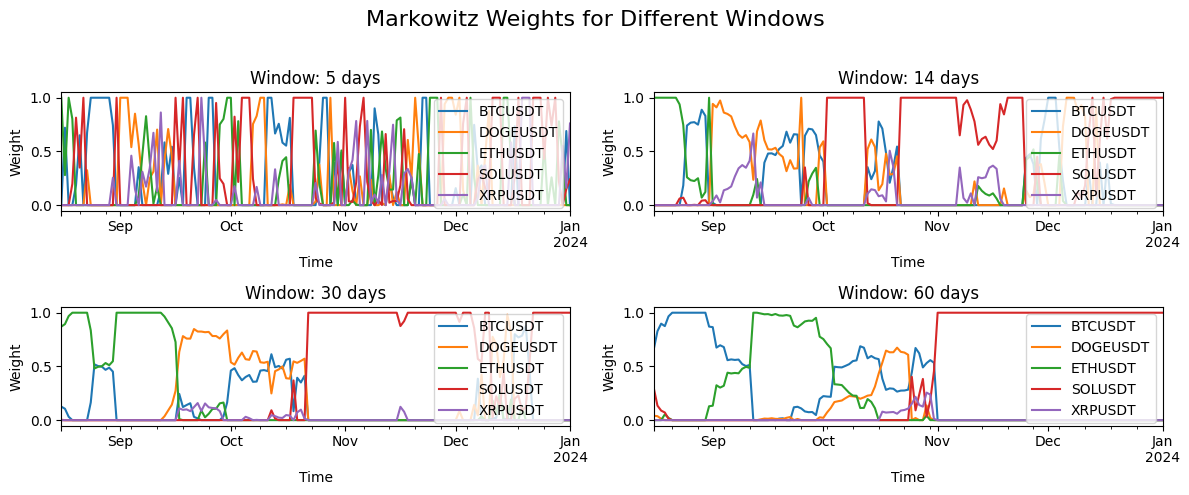

In [27]:
import matplotlib.pyplot as plt, numpy as np
from pypfopt import EfficientFrontier, risk_models, expected_returns

MarkMVO = []
MarkMVO_windows = PredMVO1_windows # windows = [30, 180, 480, 9999]
# MarkMVO_windows = windows = [30, 180, 480, 9999]
for window in MarkMVO_windows:
    portfolio_returns = []
    portfolio_weights = []
    start_date = pd.Timestamp('2023-08-14')

    # Iterate through each day after March 1, 2024
    for current_date in dfs[-1].index[dfs[-1].index > start_date]:
        if current_date > pd.Timestamp('2023-12-31'): break
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]

        # Calculate expected returns and covariance matrix using the latest data
        mean_returns = expected_returns.mean_historical_return(data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        weights["day"] = current_date + pd.Timedelta(days=1)

        # Calculate portfolio return using today's weights
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)

    # Convert portfolio returns into a DataFrame with appropriate index
    # portfolio_returns_df = pd.DataFrame(portfolio_returns, index=pd.date_range(start=start_date, periods=len(portfolio_returns), freq='D'), columns=['Portfolio Return'])

    # Plot the portfolio returns
    # (1 + portfolio_returns_df).cumprod().plot(figsize=(10, 6), title="Cumulative Portfolio Returns")
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    # plt.show()
    plt.close()

    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    MarkMVO.append(portfolio_weights)

fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(MarkMVO):
        MarkMVO[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

There are a number of ways that we can incorporate prediction in the optimization program.

1. Use the predictions to augment the "historical" price data

    Note that for larger windows, we will have to augment this (so it's weighted more in the mean and covariance calculations)
2. Use the predictions to shift the locally expected mean returns (but use very long historical correlation)
3. Dynamically rebalance the portfolio weights


NOTE: what does the "current_date" in the for loop mean?
1. At the end of the day "current_date", we decide the portfolio weights
2. Before and including "current_date," we have all our historical data
3. The price prediction is for the day after "current_date"

The index of portfolio_weights is the day on which the weights are being used.

c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


1 BTCUSDT     -0.881708
DOGEUSDT    -0.993402
ETHUSDT     19.123187
SOLUSDT     -0.999983
XRPUSDT      2.731408
dtype: float64 BTCUSDT     -0.881708
DOGEUSDT    -0.993402
ETHUSDT     19.123187
SOLUSDT     -0.999983
XRPUSDT      2.731408
dtype: float64


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


5 BTCUSDT     -0.881708
DOGEUSDT    -0.993402
ETHUSDT     19.123187
SOLUSDT     -0.999983
XRPUSDT      2.731408
dtype: float64 BTCUSDT    -0.694525
DOGEUSDT   -0.938543
ETHUSDT     4.300001
SOLUSDT    -0.997776
XRPUSDT     1.078295
dtype: float64


c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(
c:\Users\ic2594\AppData\Local\miniconda3\Lib\site-packages\pypfopt\risk_models.py:70: UserWarning: The covariance matrix is non positive semidefinite. Amending eigenvalues.
  warnings.warn(


10 BTCUSDT     -0.881708
DOGEUSDT    -0.993402
ETHUSDT     19.123187
SOLUSDT     -0.999983
XRPUSDT      2.731408
dtype: float64 BTCUSDT    -0.533434
DOGEUSDT   -0.833573
ETHUSDT     1.921501
SOLUSDT    -0.980292
XRPUSDT     0.600443
dtype: float64
1 BTCUSDT       -0.055620
DOGEUSDT      -0.894167
ETHUSDT        3.378277
SOLUSDT     3372.668380
XRPUSDT        1.614756
dtype: float64 BTCUSDT       -0.055620
DOGEUSDT      -0.894167
ETHUSDT        3.378277
SOLUSDT     3372.668380
XRPUSDT        1.614756
dtype: float64
5 BTCUSDT       -0.055620
DOGEUSDT      -0.894167
ETHUSDT        3.378277
SOLUSDT     3372.668380
XRPUSDT        1.614756
dtype: float64 BTCUSDT      -0.043534
DOGEUSDT     -0.825670
ETHUSDT       2.153489
SOLUSDT     553.727425
XRPUSDT       1.111878
dtype: float64
10 BTCUSDT       -0.055620
DOGEUSDT      -0.894167
ETHUSDT        3.378277
SOLUSDT     3372.668380
XRPUSDT        1.614756
dtype: float64 BTCUSDT      -0.034234
DOGEUSDT     -0.745146
ETHUSDT       1.456736
SOLUSD

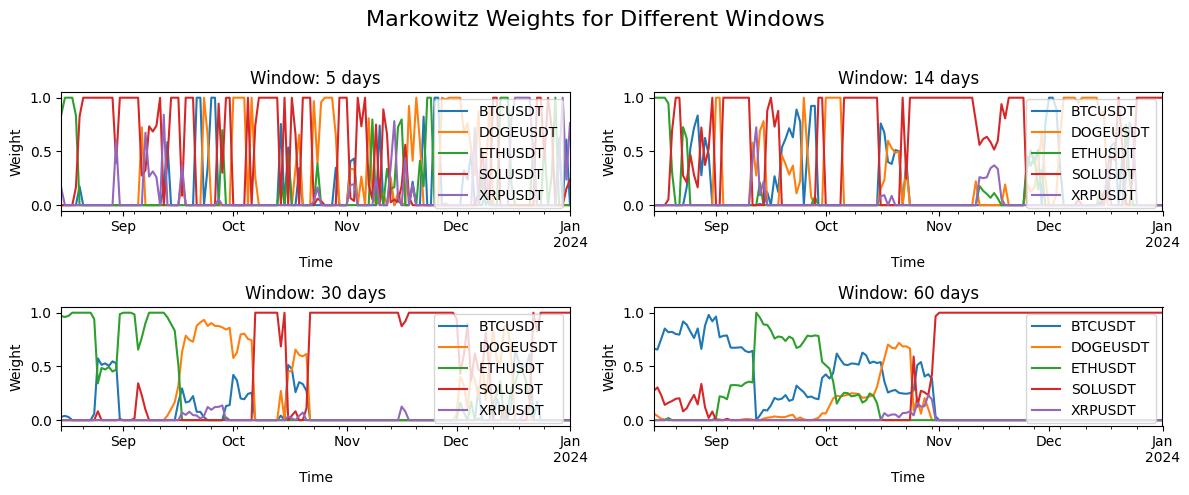

In [28]:

PredMVO1_windows = windows = [5, 14, 30, 60]
extra_days = [1, 5, 10]
PredMVO1 = []
PredMVO2 = []
PredMVO3 = []

# lmbda = 0.5

def get_PredMVO1_weights(window, extra_days):
    portfolio_weights = []
    for current_date in dfs[-1].index[dfs[-1].index >= start_date]:
        if current_date > pd.Timestamp('2023-12-31'): break
        # Filter data up to the current date
        data_up_to_today = opens.loc[:current_date]
        if len(data_up_to_today) > window:
            data_up_to_today = data_up_to_today[-window:]


        next_day = current_date + pd.Timedelta(days=1)
        new_row = pd.DataFrame([pred_close.loc[next_day]], index=[next_day])
        extra_data_up_to_today = pd.concat([data_up_to_today, new_row])

        # Calculate expected returns and covariance matrix using the latest data
        old_mean_returns = expected_returns.mean_historical_return(extra_data_up_to_today, frequency=365)
        cov_matrix = risk_models.sample_cov(data_up_to_today)

        returns = extra_data_up_to_today.pct_change().dropna()
        n = len(returns) - 1

        # Define weights: N/(N+M) for each of the first N rows, M/(N+M) for the last
        M = extra_days
        N = n
        weights_array = np.full(N, 1 / (N + M))
        weights_array = np.append(weights_array, M / (N + M))  # last observation gets weight M/(N+M)

        # Normalize in case of numerical issues
        weights_array = weights_array / weights_array.sum()

        # Convert to DataFrame for alignment
        weights_series = pd.Series(weights_array, index=returns.index)

        # Weighted mean
        mu_weighted = returns.mul(weights_series, axis=0).sum()

        # Weighted covariance (bias-corrected)
        centered = returns - mu_weighted
        weighted_cov = centered.mul(weights_series, axis=0).T @ centered
        correction = 1 / (1 - np.sum(weights_array**2))
        cov_weighted = correction * weighted_cov

        mean_returns = expected_returns.mean_historical_return(pd.concat([data_up_to_today, *([new_row] * M)]), frequency=365)

        # Optimize for maximum Sharpe ratio
        ef = EfficientFrontier(mean_returns, cov_matrix)
        # ef = EfficientFrontier(mu_weighted, cov_weighted)
        # ef = EfficientFrontier(mu_weighted, cov_matrix)
        weights = ef.max_sharpe(risk_free_rate=-10)
        cleaned_weights = ef.clean_weights()

        # Get returns for the current day (next day's returns based on today's weights)
        daily_returns = pd.DataFrame(
            {ticker: df.loc[current_date, "Return"] for ticker, df in zip(tickers, dfs)},
            index=[current_date]
        ).loc[current_date]

        # Calculate portfolio return using today's weights

        # Normalize portfolio weights to ensure they sum to 1
        weights_sum = sum(i for i in weights.values() if i >= 0)
        if weights_sum > 10:
            print(weights)
        if weights_sum != 0:
            weights = {key: max(0, value / weights_sum) for key, value in weights.items()}
        weights["day"] = next_day
        
        portfolio_weights.append(weights)
        # portfolio_return = np.dot(np.array(list(weights.values())), daily_returns.values)
        # portfolio_returns.append(portfolio_return)
    print(M, old_mean_returns, mean_returns)
    portfolio_weights = pd.DataFrame(portfolio_weights)
    portfolio_weights.index = portfolio_weights["day"]
    portfolio_weights.drop(columns=["day"], inplace=True)
    return portfolio_weights

for window in PredMVO1_windows:
    PredMVO1.append(get_PredMVO1_weights(window, 1))
    PredMVO2.append(get_PredMVO1_weights(window, 5))
    PredMVO3.append(get_PredMVO1_weights(window, 10))


fig, axes = plt.subplots(2, 2, figsize=(12, 5))
fig.suptitle("Markowitz Weights for Different Windows", fontsize=16)

for i, ax in enumerate(axes.flatten()):
    if i < len(PredMVO1):
        PredMVO1[i].plot(ax=ax, title=f"Window: {windows[i]} days")
        ax.set_xlabel("Time")
        ax.set_ylabel("Weight")
        ax.legend(loc="upper right")
    else:
        ax.axis("off")  # Turn off unused subplots

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

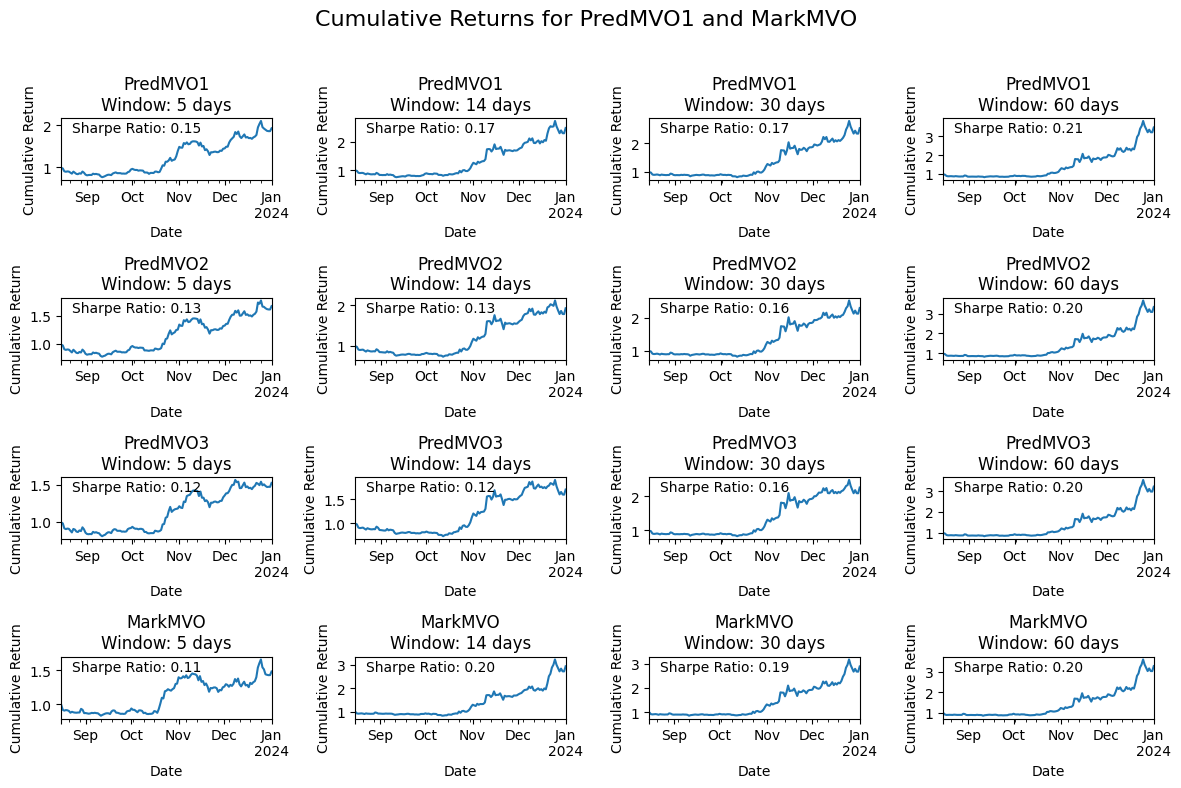

In [29]:
def calculate_cumulative_returns(df):
    portfolio_returns = np.array([
        np.dot(true_returns.loc[date], df.loc[date]) for date in df.index
    ])
    cumulative_returns = (1 + portfolio_returns).cumprod()
    cumulative_returns = pd.DataFrame(cumulative_returns, index=df.index, columns=["cumu"])
    cumulative_returns["port"] = portfolio_returns
    return cumulative_returns

# Plot cumulative returns for each DataFrame in PredMVO1 and MarkMVO
fig, axes = plt.subplots(4, 4, figsize=(12, 8))
fig.suptitle("Cumulative Returns for PredMVO1 and MarkMVO", fontsize=16)

for i, (df, ax) in enumerate(zip(PredMVO1 + PredMVO2 + PredMVO3 + MarkMVO, axes.flatten())):
    if i < len(PredMVO1):
        category = "PredMVO1"
        window = PredMVO1_windows[i % len(PredMVO1_windows)]
    elif i < len(PredMVO1) + len(PredMVO2):
        category = "PredMVO2"
        window = PredMVO1_windows[(i - len(PredMVO1)) % len(PredMVO1_windows)]
    elif i < len(PredMVO1) + len(PredMVO2) + len(PredMVO3):
        category = "PredMVO3"
        window = PredMVO1_windows[(i - len(PredMVO1) - len(PredMVO2)) % len(PredMVO1_windows)]
    else:
        category = "MarkMVO"
        window = MarkMVO_windows[(i - len(PredMVO1) - len(PredMVO2) - len(PredMVO3)) % len(MarkMVO_windows)]

    cumulative_returns = calculate_cumulative_returns(df)
    cumulative_returns["cumu"].plot(ax=ax, title=f"{category}\nWindow: {window} days")

    if cumulative_returns["port"].std() < 1e-15:
        sharpe_ratio = np.nan
    else:
        sharpe_ratio = cumulative_returns["port"].mean() / cumulative_returns["port"].std()
    ax.text(0.05, 0.95, f"Sharpe Ratio: {sharpe_ratio:.2f}", transform=ax.transAxes, fontsize=10, verticalalignment='top')
    ax.set_xlabel("Date")
    ax.set_ylabel("Cumulative Return")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


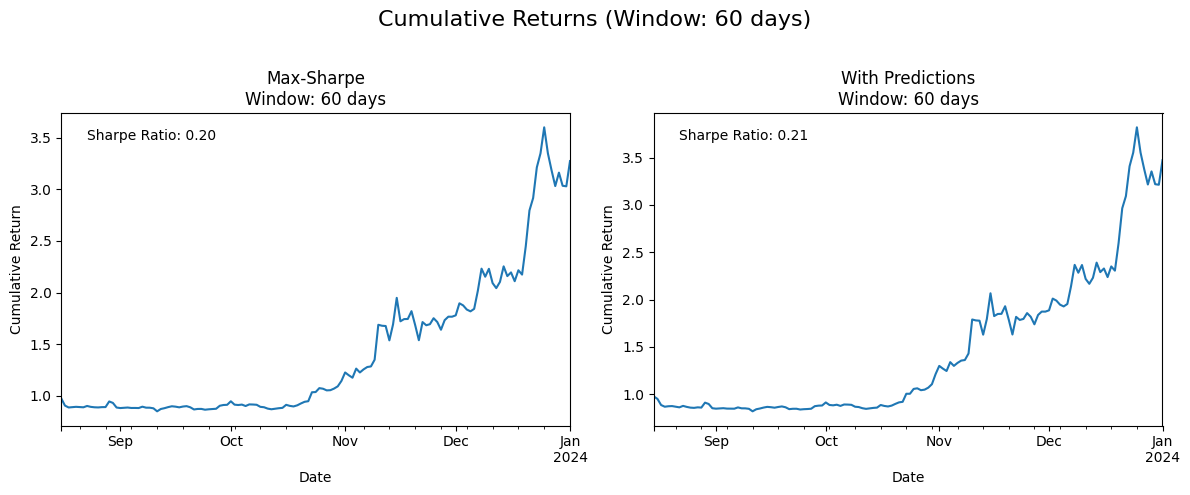

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
fig.suptitle("Cumulative Returns (Rebalancing Window: 60 days)", fontsize=16)

# Plot PredMVO1 window[3]
cumulative_returns_predmvo1 = calculate_cumulative_returns(PredMVO1[3])
cumulative_returns_predmvo1["cumu"].plot(ax=axes[0], title="With Predictions\nWindow: 60 days")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Cumulative Return")

# Calculate and display Sharpe ratio for PredMVO1
if cumulative_returns_predmvo1["port"].std() < 1e-15:
    sharpe_ratio_predmvo1 = np.nan
else:
    sharpe_ratio_predmvo1 = cumulative_returns_predmvo1["port"].mean() / cumulative_returns_predmvo1["port"].std()
axes[0].text(0.05, 0.95, f"Sharpe Ratio: {sharpe_ratio_predmvo1:.2f}", transform=axes[0].transAxes, fontsize=10, verticalalignment='top')

# Plot MarkMVO window[3]
cumulative_returns_markmvo = calculate_cumulative_returns(MarkMVO[3])
cumulative_returns_markmvo["cumu"].plot(ax=axes[1], title="Max-Sharpe\nWindow: 60 days")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Cumulative Return")

# Calculate and display Sharpe ratio for MarkMVO
if cumulative_returns_markmvo["port"].std() < 1e-15:
    sharpe_ratio_markmvo = np.nan
else:
    sharpe_ratio_markmvo = cumulative_returns_markmvo["port"].mean() / cumulative_returns_markmvo["port"].std()
axes[1].text(0.05, 0.95, f"Sharpe Ratio: {sharpe_ratio_markmvo:.2f}", transform=axes[1].transAxes, fontsize=10, verticalalignment='top')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
